### The equivalent BBGKY Heirarchy ( corrected upto 2nd order )for 1D spin syste based on Curie Weiss spin system with transverse symmetry breaking field.

The correlation G-matrix and $\delta \sigma$ are zero initially.
<br>
According to Mori's paper the model is ZZX configuration. But in our study, we have done XXZ model so fur. So i have rewritten the ZZX model into XXZ model to compare the time evolution of 1D spin with BBGKY heirarchy with TLS, Meanfield etc.
<br>
For simulation, we have taken the intial state as the eigen state of the inverse-transeverse field. Let me simplify this. In  current $\bf XXZ$ model, the transverse symmetry breaking field is in the Z-direction. Thus we are upto chose the eigen state of $\sigma^x$ as initial state.
<br>
Other initial conditions are as Jz = -ve (Jx,Jy are zero), hx = -ve (hy,hz are zero).
<br>
The symmetry breaking field contains a dc part. I have checked that in case of even numbered spin in quantum system, for exact numerical simulation, dc part fits correctly the freezing condition implied as per Bessel's first root.
#### Reference:

##### 1. Mori, T. “[1810.01584] Prethermalization in the Transverse-Field Ising Chain with Long-Range Interactions.” Accessed October 30, 2019. https://arxiv.org/abs/1810.01584.


#### When $\alpha = 0$, i.e. in the mean field limit

run started!
time taken  38.98822331428528
code is okay!!


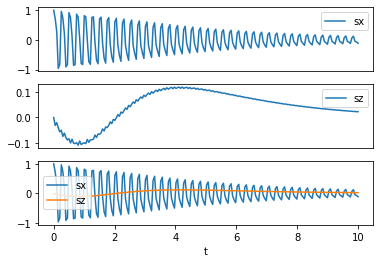

In [1]:
import numpy as np
from scipy.sparse import dia_matrix
from math import *
from itertools import combinations
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time


start = time.time()

# Required parameters
N = 4           # Insert an integer value for N = no. of spin sites
alpha = 0.0     # the number of order parameter; alpha = 0 is meanfield limit
omega = 25.0    # Insert a float value for omega
hdc = 0.1       # This is the dc part of the symmetry breaking field
amp = 25.0      # amplitude of the symmetry breaking field
n = 200         # Number of steps for odeint

# Initial values: ACCORDING To XXZ model
jx, jy, jz = -1.0, 0.0, 0.0 
hx, hy, hz = 0.0, 0.0, -1.0 * amp

# Periodic Boundary Condition
def jmat(N, alpha):
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()
J = jmat(N, alpha)


def gcorr(G,t,k,a,b,wmat,gmat,v_vec,f_vec):
    left = sum(np.dot(wmat[a,c], gmat[k,c,b]) + np.dot(wmat[b,c], gmat[k,a,c]) for c in np.arange(3))
    mdl1 = v_vec[a] * sum(np.dot(J[0, j], gmat[np.absolute(j-k) + 1, b,0]) for j in np.arange(1,k))
    mdl2 = v_vec[b] * sum(np.dot(J[k, j], gmat[j,0,a]) for j in np.arange(1,k))
    rght = J[0, k] * (np.dot(v_vec[a], f_vec[b]) + np.dot(v_vec[b], f_vec[a]))
    gc   = (left + mdl1 + mdl2 + rght)
    return gc

def g_t(k,i,j,t,gstate,wmat,gmat,v_vec,f_vec):
    d_t = t
    a,b = i,j
    G = odeint(gcorr, gstate, d_t, args=((k,a,b,wmat,gmat,v_vec,f_vec)))
    gstate = G[1]
    return G[1]

def xxz_model(dxyz, tspan, gstate,ts):
    t = ts
    sx, sy, sz = dxyz[0], dxyz[1], dxyz[2]
    
    v_vec = np.array([[0.0], [ 2 * sz], [- 2 * sy]])
    f_vec = np.array([[1 - sx * sx], [- sy * sx], [- sz * sx]])
    hz1 = hz * np.cos(omega * t[1]) + hdc
    wmat = np.array([[0, 2 * hz1, 0], [- 2 * hz1, 0, 2 * (sx + hx)], [0, - 2 * (sx + hx), 0]])

    dsx = 2.0 * hz1 * sy
    # here t[1] is taken as in the odeint, the integration in limited in lower and upper boundary condition.
    # After each "Odeint" operation, the pointer or the programming courser goes to the final boundary condition.
    # which is t[1] here. Thats the reason I have taken time value as t[1] at the line bellow.
    dsy = 2.0 * sx * sz + 2.0 * hx * sz - 2.0 * hz1 * sx  + 2.0 * (sum(J[0,j] * g_t(j,0,2,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N)))
    dsz = - 2.0 * sy * sx - 2.0 * hx * sy - 2.0 * sum(J[0,j] * g_t(j,0,1,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N))

    dxyz = [dsx, dsy, dsz]   
    return dxyz

z0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
t = np.linspace(0.0, 10.0,n)
sx, sy, sz = np.zeros(n), np.zeros(n), np.zeros(n)
sx[0],sy[0],sz[0] = z0[0],z0[1],z0[2]
gstate = 0.0

gmat = np.zeros((N,3,3))
ttt = 0.0              #initialze the time as zero
wmat = np.array([[0, 2 * ( hz * np.cos(omega * ttt) + hdc), 0], \
                      [- 2 * (hz * np.cos(omega * ttt) +hdc), 0, 2 * (sx[0] + hx)],\
                      [0, - 2 * (sx[0] + hx), 0]])
v_vec = np.array([[0.0], [ 2 * sz[0]], [- 2 * sy[0]]])
f_vec = np.array([[1 - sx[0] * sx[0]], [- sy[0] * sx[0]], [- sz[0] * sx[0]]])

print("run started!")

for i in range(1,n):
    # as the odeint for coupled differential equation runs for single time interval due to its coupled behavior.
    tspan = [t[i-1],t[i]]
    ts = tspan
    # in args=((gstate, ts)) , ts is taken as argument, because odeint runs more interval than the time steps entered 
    # in the "odeint()" syntax. Like if I have entered the the time stpes= np.linspace(0,1,10), but in reality
    # it runs more steps in the "odeint" function when it runs. Thus is can cause ambiguity in the time steps I want
    # in other calculations in "xxz_model" function. So i have made "ts" as argumenmt.
    dxyz = odeint(xxz_model, z0, tspan, args=((gstate,ts)))
    sx[i], sy[i], sz[i] = dxyz[1][0], dxyz[1][1], dxyz[1][2]
    
    z0 = dxyz[1] 

#np.savetxt("bbgky_t_sx_sz_N8_alpha0.txt",np.vstack((np.real(t), np.real(sx), np.real(sz))).T)
elapse= time.time() - start
print("time taken ", elapse)
print("code is okay!!")
                                     
plt.title("time evolution for BBGKY xxz model")
plt.subplot(311)
plt.plot(t,sx, label="sx")
#plt.ylim(-1,1)
plt.legend()
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.subplot(312)
plt.plot(t,sz, label="sz")
plt.legend()
#plt.ylim(-1,1)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.subplot(313)
plt.plot(t,sx, label="sx")
plt.plot(t,sz, label="sz")
plt.legend()
#plt.ylim(-1,1)
plt.xlabel("t")
#plt.savefig("bbgky_zzx_model_N8_alpha0.jpeg", dpi=300)
plt.show()